In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 19a

## Simple RNN - One feature


<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

import tensorflow as tf

from utils.helper import fn_plot_tf_hist

%matplotlib inline

2024-07-20 11:32:56.786974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 11:32:56.799767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 11:32:56.803513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 11:32:56.813574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 11:32:57.626366: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

EPOCHS = 30  # number of cycles to run
ALPHA = 0.1  # learning rate
TEST_SIZE = 0.2 # What fraction we want to keep for testing
BATCH_SIZE = 32

# Set parameters for decoration of plots
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }
CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Load Weather Data

In [4]:
dataFilename = 'weatherHistory.csv'
data_df = pd.read_csv(os.path.join(inpDir, dataFilename))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
data_df.shape

(96453, 12)

In [6]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], 
                                     utc=True)

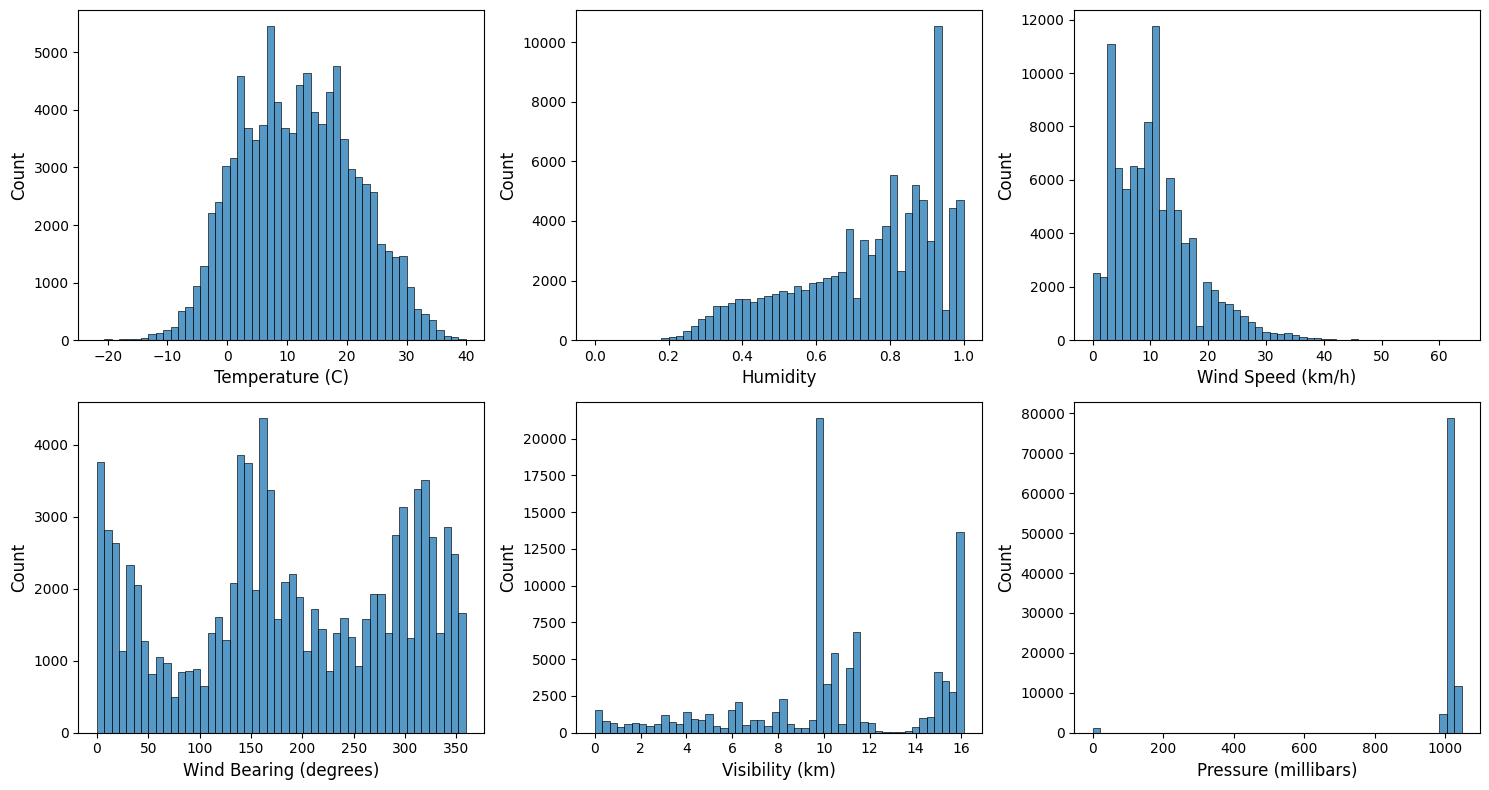

In [7]:
num_cols = ['Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)',
             'Visibility (km)', 'Pressure (millibars)']

fig, axes = plt.subplots(2,3, figsize=(15,8))

axes = axes.ravel()

for count, col in enumerate(num_cols):
    
    ax =axes[count]
    
    sns.histplot(data_df, x = col, ax = ax, bins = 50)

plt.tight_layout()

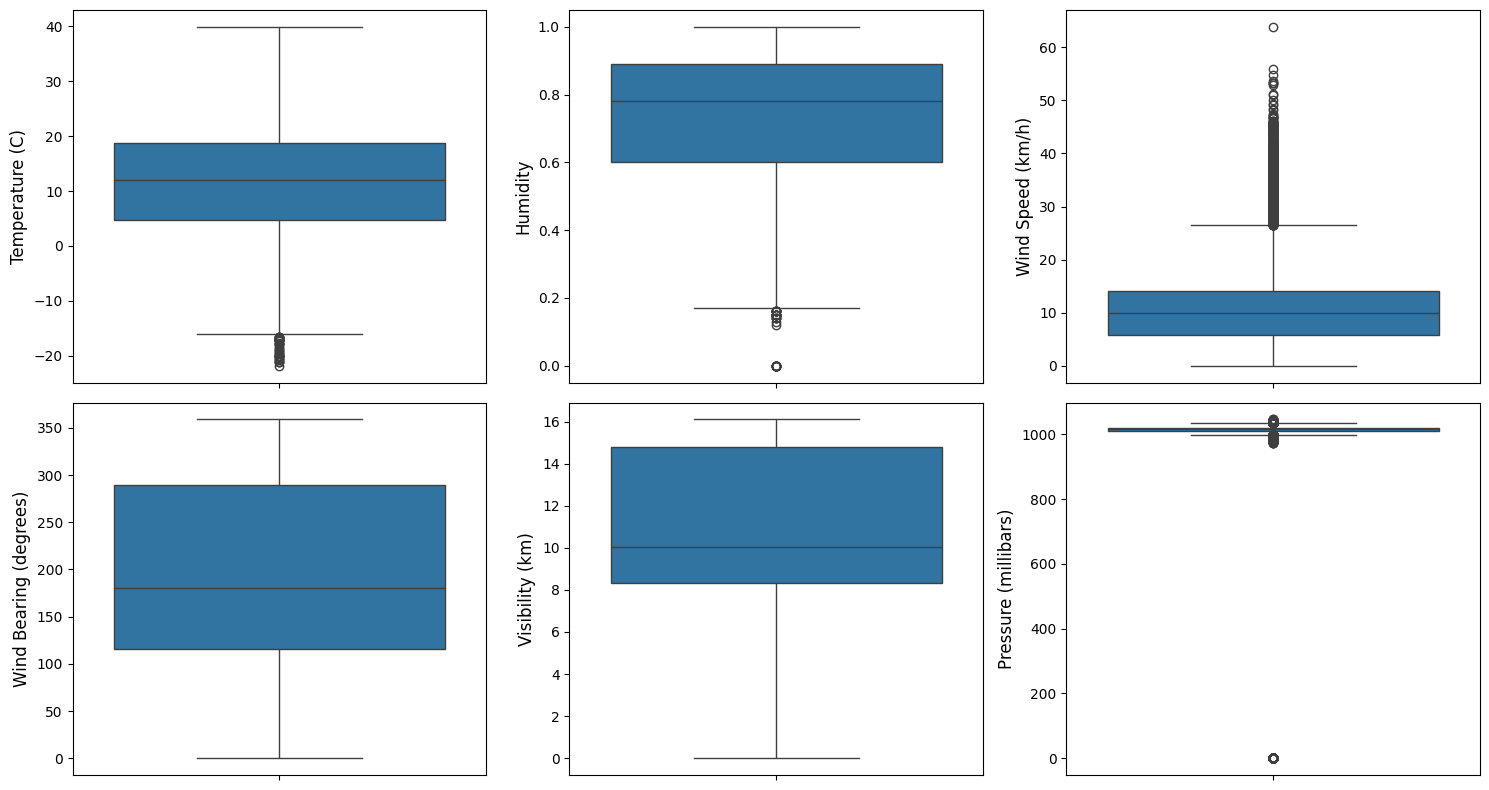

In [8]:
fig, axes = plt.subplots(2,3, figsize=(15,8))

axes = axes.ravel()

for count, col in enumerate(num_cols):

    sns.boxplot(y=col, data=data_df, ax = axes[count])

plt.tight_layout()
# Show the plot
plt.show()

In [9]:
data_df[num_cols].corr()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars)
Temperature (C),1.000000,-0.632255,0.008957,0.029988,0.392847,-0.005447
Humidity,-0.632255,1.000000,-0.224951,0.000735,-0.369173,0.005454
Wind Speed (km/h),0.008957,-0.224951,1.000000,0.103822,0.100749,-0.049263
Wind Bearing (degrees),0.029988,0.000735,0.103822,1.000000,0.047594,-0.011651
Visibility (km),0.392847,-0.369173,0.100749,0.047594,1.000000,0.059818
Pressure (millibars),-0.005447,0.005454,-0.049263,-0.011651,0.059818,1.000000


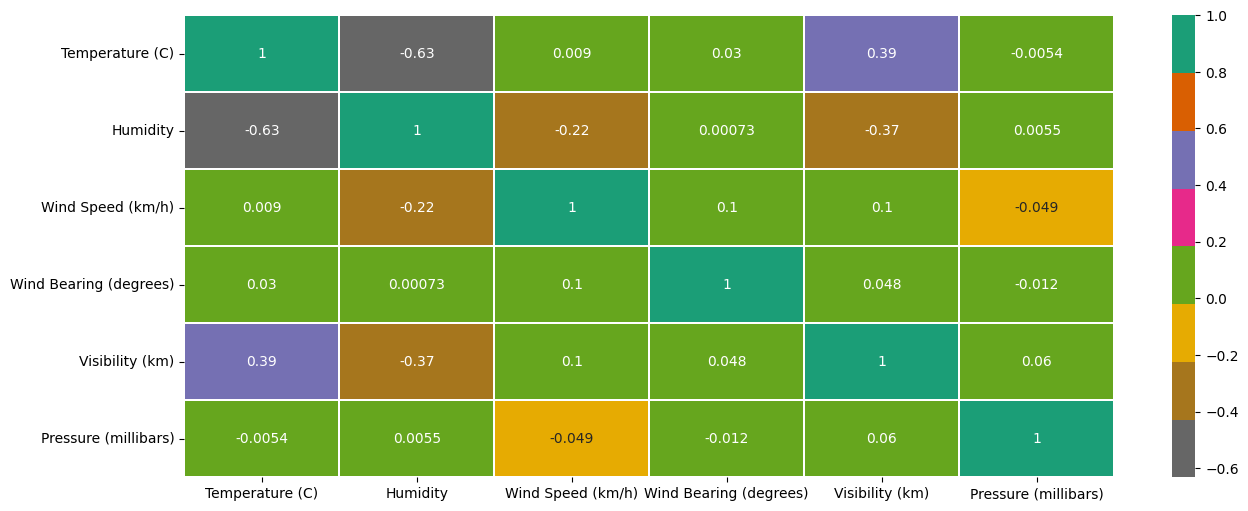

In [10]:
sns.heatmap(data_df[num_cols].corr(), annot=True, cmap='Dark2_r', linewidths = .2)
plt.show()

In [11]:
temp_df = data_df[['datetime', 'Temperature (C)']]
temp_df = temp_df.sort_values('datetime', axis=0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df.head()

,datetime,Temperature (C)
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [12]:
temp_df = temp_df.rename({'Temperature (C)': 'temp'}, axis=1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [13]:
# comment/uncomment following lines if you want part or full dataset

# startDate = pd.to_datetime('2007-1-1', utc=True)
# endDate = pd.to_datetime('2008-1-1', utc=True)
# temp_df = temp_df[(temp_df['datetime']  >= startDate) & (temp_df['datetime']  < endDate)]

In [14]:
temp_df.reset_index(drop=True, inplace = True)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


In [15]:
temp_df.shape

(96453, 2)

## Plotting samples

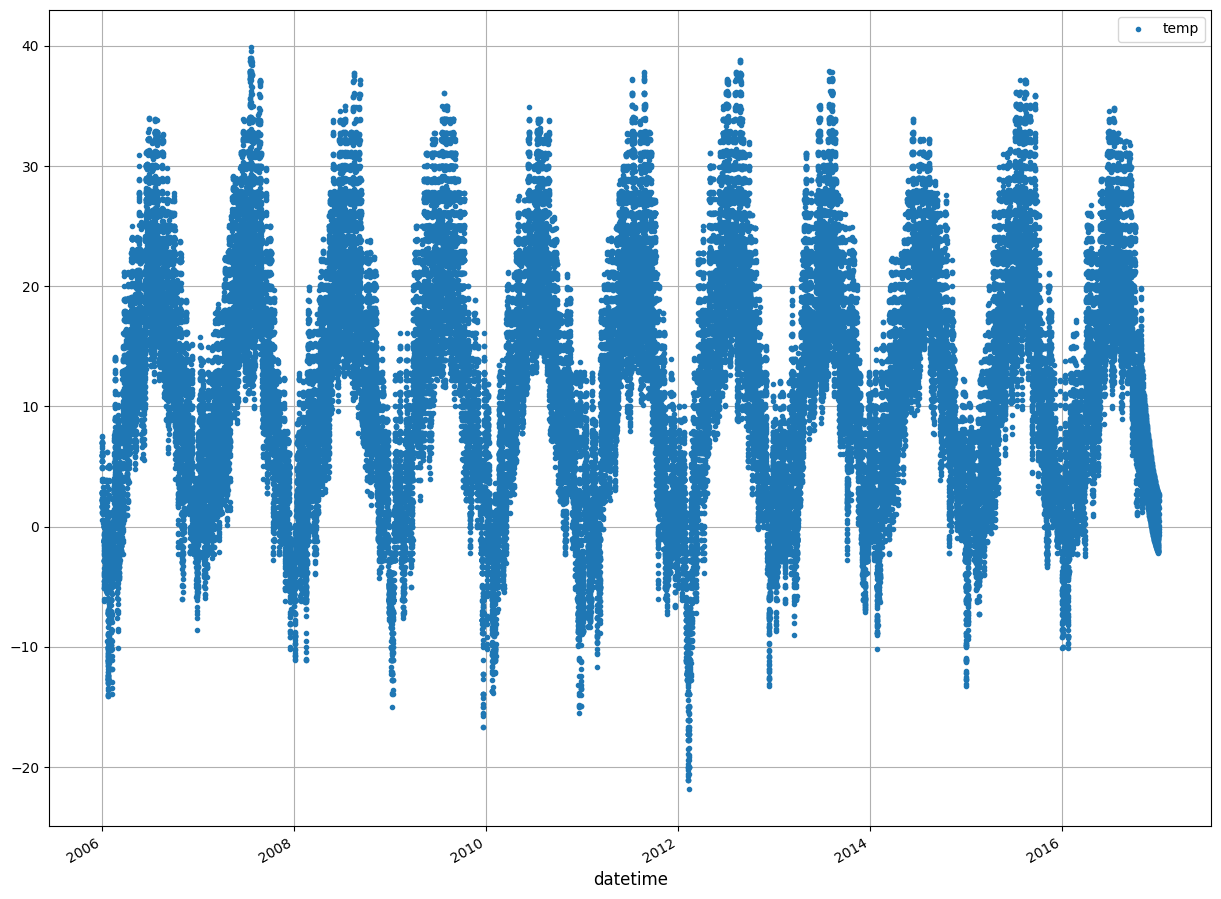

In [16]:
fig, ax = plt.subplots(figsize = (15,12))
temp_df.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()

In [17]:
h_units = 100
input_shape = (1, 10000)

model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Input(shape=input_shape))

model.add(tf.keras.layers.SimpleRNN(units = h_units, 
                                    activation = 'tanh' ))

model.add(tf.keras.layers.Dense(1, activation = 'linear' ))

I0000 00:00:1721455382.554241   87965 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721455382.588716   87965 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721455382.593055   87965 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721455382.598076   87965 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [18]:
wax = model.get_weights()[0].shape
waa = model.get_weights()[1].shape
baa = model.get_weights()[2].shape
way = model.get_weights()[3].shape
bay = model.get_weights()[4].shape

print ('Shape of Matrix:')
print ('Wax = ', wax,'; Waa = ', waa, '; baa = ', baa,'; Way = ', way,'; bay = ', bay)

Shape of Matrix:
Wax =  (10000, 100) ; Waa =  (100, 100) ; baa =  (100,) ; Way =  (100, 1) ; bay =  (1,)


In [19]:
temp_df

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
...,...,...
96448,2016-12-31 18:00:00+00:00,0.488889
96449,2016-12-31 19:00:00+00:00,0.072222
96450,2016-12-31 20:00:00+00:00,-0.233333
96451,2016-12-31 21:00:00+00:00,-0.472222


In [20]:
time_step = 24

In [21]:
temp_df.shape[0]

96453

In [22]:
y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [23]:
y_idx

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [24]:
y_df.shape, len(y_df)*time_step

((4018, 2), 96432)

In [25]:
temp_df.shape

(96453, 2)

In [26]:
X_df = temp_df.iloc[range(len(y_df) * time_step)]

In [27]:
X_df['temp'].values.shape

(96432,)

In [28]:
y_df.shape

(4018, 2)

In [29]:
X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))
X.shape

(4018, 24)

In [30]:
X = X[:, :23]
X.shape

(4018, 23)

## Note

Need to reshape the inputs into the 3D format as expected by the SimpleRNNs, namely [samples, timesteps, features].

In [31]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X.shape

(4018, 23, 1)

In [32]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [33]:
h_units = 256
input_shape=(time_step-1, 1 ) # we are using one feature only.
kernel_initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape = input_shape))

model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                    kernel_initializer=kernel_initializer,
                                    activation = 'tanh'))

model.add(tf.keras.layers.Dense(1, 
                                kernel_initializer=kernel_initializer,
                                activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 256)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE, 
                    verbose=1)

Epoch 1/30


I0000 00:00:1721455383.851160   88052 service.cc:146] XLA service 0x7ed6f00d3760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721455383.851195   88052 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-20 11:33:03.876321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-20 11:33:04.002752: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 36/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0222 - root_mean_squared_error: 1.7057

I0000 00:00:1721455384.354344   88052 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.0913 - root_mean_squared_error: 1.4157 - val_loss: 0.7992 - val_root_mean_squared_error: 0.8940
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2389 - root_mean_squared_error: 1.1118 - val_loss: 0.8002 - val_root_mean_squared_error: 0.8946
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2244 - root_mean_squared_error: 1.1053 - val_loss: 0.9348 - val_root_mean_squared_error: 0.9669
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2713 - root_mean_squared_error: 1.1253 - val_loss: 0.7500 - val_root_mean_squared_error: 0.8660
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1794 - root_mean_squared_error: 1.0850 - val_loss: 0.7328 - val_root_mean_squared_error: 0.8560
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1756 - root_mean_squared_error: 1.0832 - val_loss: 0.6979 - val_root_mean_squared_error: 0.8354
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.

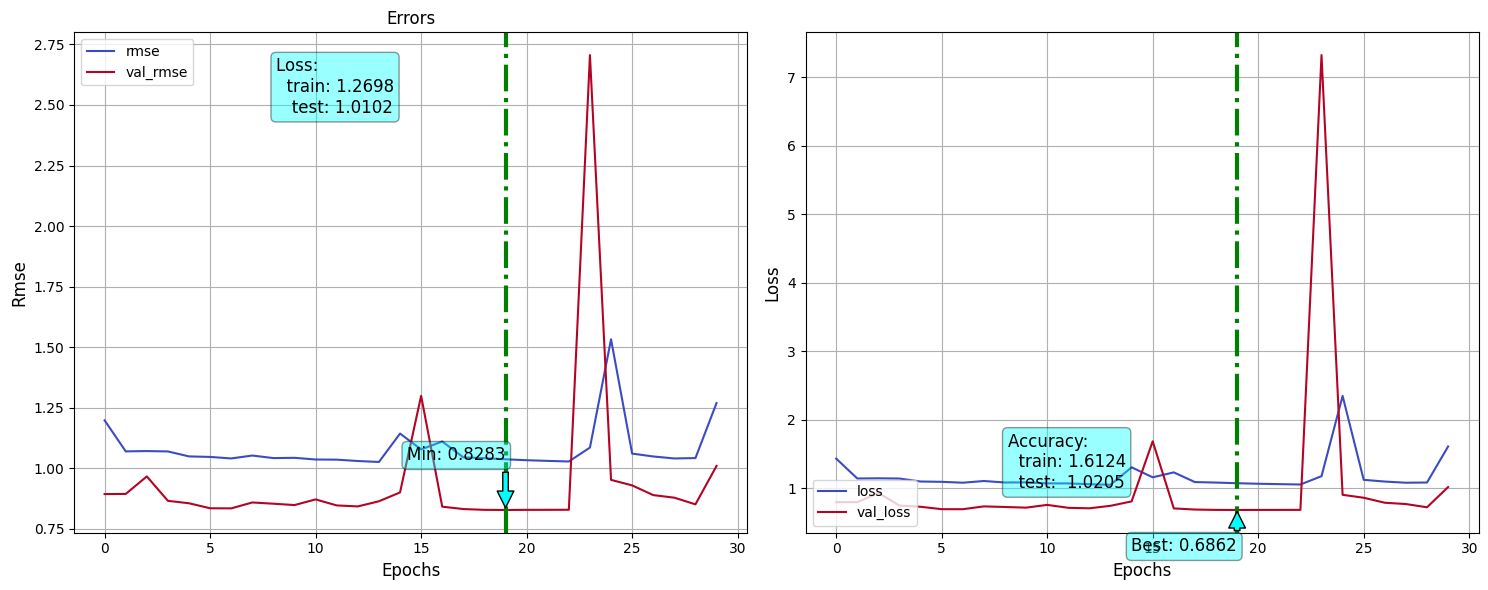

In [36]:
hist_df = pd.DataFrame(history.history)
hist_df = hist_df.rename({'root_mean_squared_error': 'rmse', 'val_root_mean_squared_error' : 'val_rmse'}, axis=1)


fn_plot_tf_hist(hist_df)

In [37]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [38]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,5.400986
48,2006-01-02,1.694444,2.004712
72,2006-01-03,2.200000,2.090884
96,2006-01-04,1.666667,2.131113
120,2006-01-05,1.805556,2.389454


In [39]:
res_df.tail()

,datetime,temp,pred
96336,2016-12-27,-1.627778,-1.582759
96360,2016-12-28,-1.677778,-1.621752
96384,2016-12-29,-1.727778,-1.663293
96408,2016-12-30,-1.777778,-1.706711
96432,2016-12-31,-1.822222,-1.744128


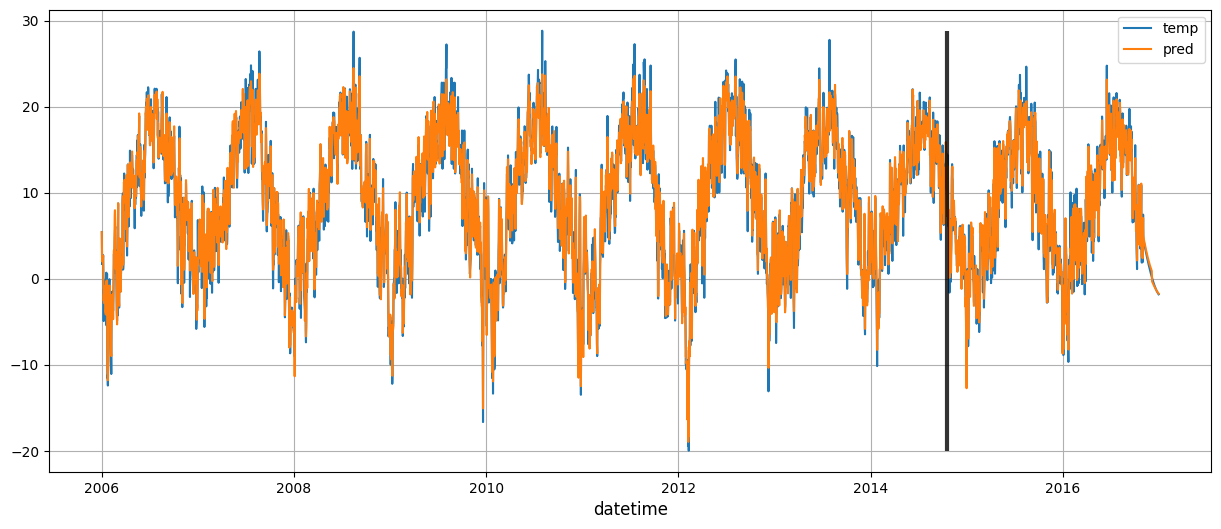

In [40]:
fig, ax = plt.subplots(figsize = (15,6))

res_df.plot(x='datetime', y=['temp','pred'], ax = ax);

ax.vlines(res_df.iloc[X_train.shape[0]]['datetime'], 
          res_df['temp'].min(), 
          res_df['temp'].max(), color = 'k', 
          linewidth=3.0, zorder=10, alpha =0.8)

ax.grid()

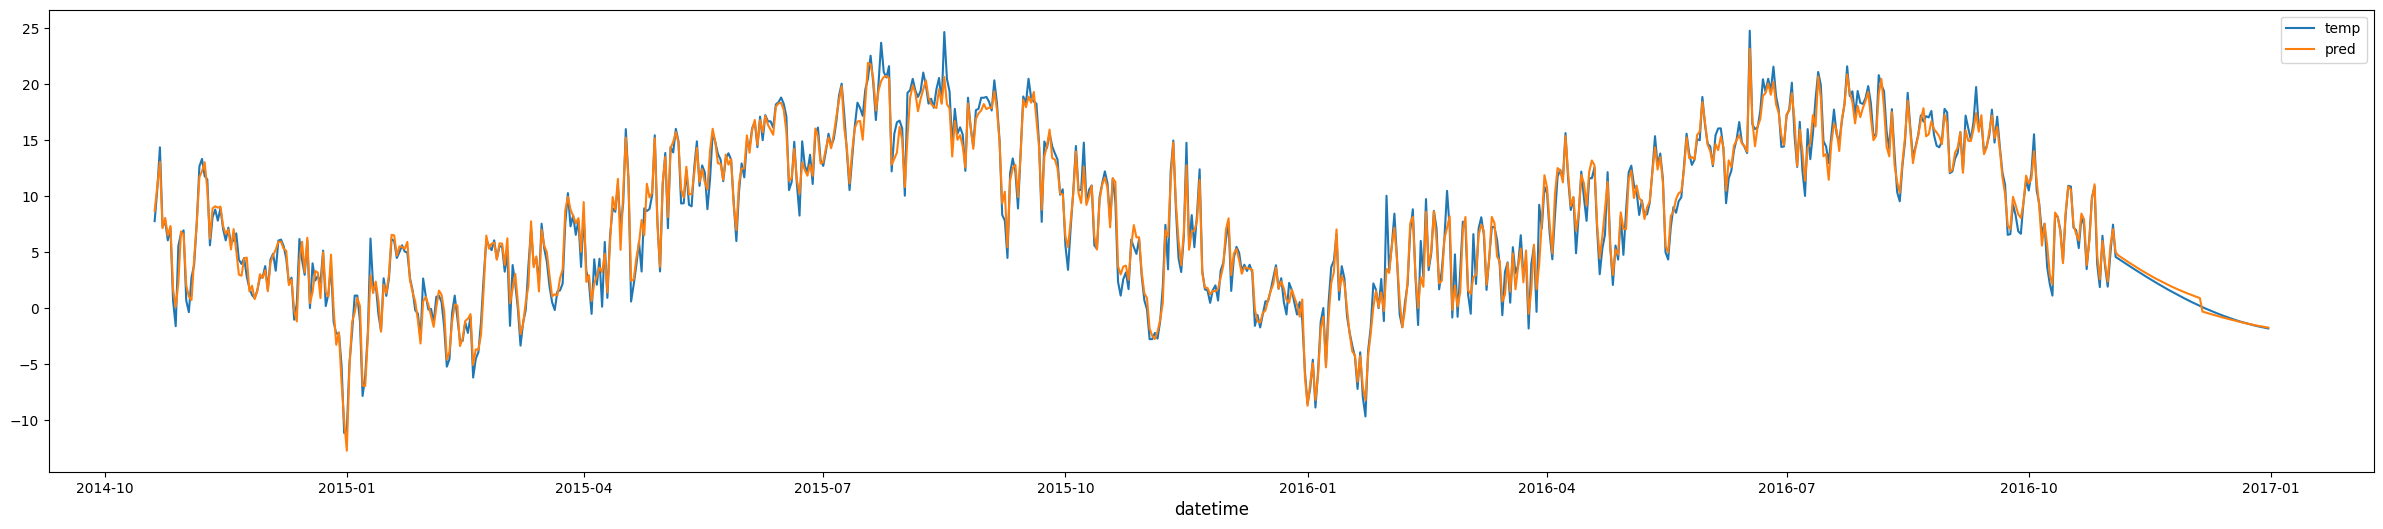

In [41]:
fig, ax = plt.subplots(figsize=(30,6))
res_df.iloc[X_train.shape[0]:].plot(x='datetime', y=['temp','pred'], ax = ax);